<table>
  <tr>
    <td><div align="left"><font size="30">Finding blobs</font></div></td>
    <td><img src="images/RVSS-logo.png" width="400"></td>
  </tr>
</table>

In [1]:
%matplotlib notebook

import sys
!{sys.executable} -m pip install machinevision-toolbox-python # used to install machinevision-toolbox into the kernel
!{sys.executable} -m pip install opencv-contrib-python==4.4.0.46 # update opencv to 4.4.0

from machinevisiontoolbox import Image
import matplotlib.pyplot as plt
import numpy as np

from spatialmath import SE3
from spatialmath import base

np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 55.7 MB 40 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


# Find objects in a binary image

We start by loading a binary image

<IPython.core.display.Javascript object>


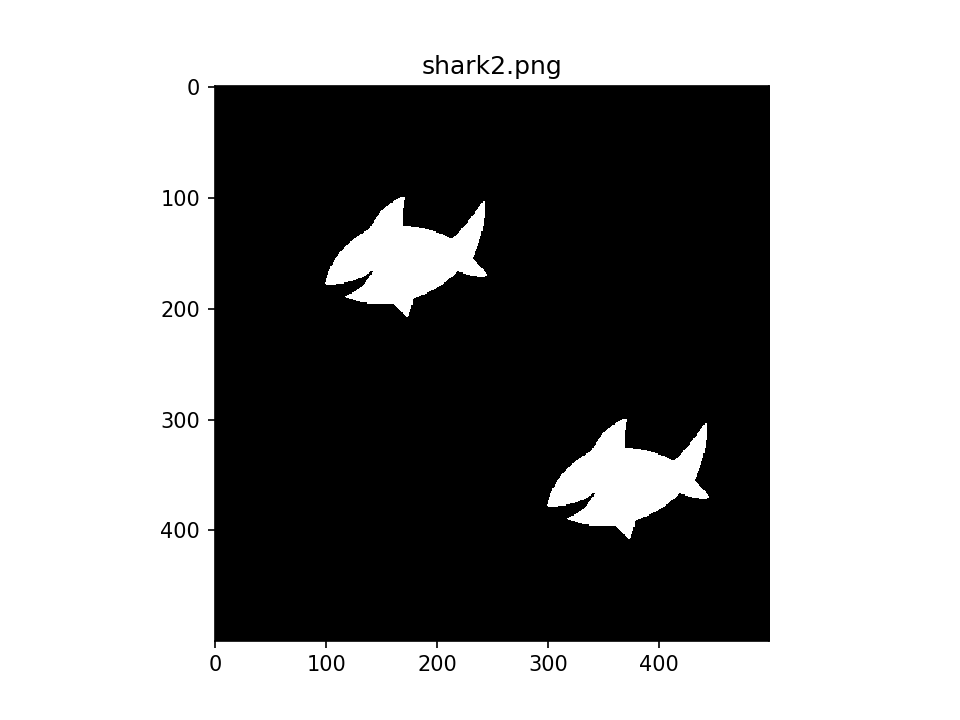

In [2]:
sharks = Image('shark2.png', grey=True)
sharks.disp();

When we look at this we see two white objects, vaguely shark shaped, against a black background.  But the *objects* are a mental construct of ours, the image is simply 250,000 black and white pixels.  How do group adjacent pixels of the same color to find the objects?

This is a very classical computer vision problem that goes by many names: blob analysis, connectivity analysis, region labelling and many more.
Such objects in a binary object are often called *blobs*.

Using this toolbox we simply write

In [3]:
blobs = sharks.blobs()

and the result is a feature object that describes *blobs*

The `blobs` object can describe a number of blobs, and in this case there are

In [4]:
len(blobs)

2

blobs.  The background is also a blob, a black blob, but here we are ignoring that.

This object can be indexed or sliced just like a list.  Each element has a number of properties such as its centroid (centre of mass)

In [5]:
blobs[0].centroid

(371.2073205542015, 355.18802011286033)

area in pixels

In [6]:
blobs[0].centroid

(371.2073205542015, 355.18802011286033)

and a bounding box

In [7]:
blobs[0].bbox

array([[299, 445],
       [300, 408]])

where the first row is the u-axis range, and the second row is the v-axis range.  Alternatively we can consider the columns: the first column is the top-left coordinate and the second column is the bottom-right coordinate.

<IPython.core.display.Javascript object>


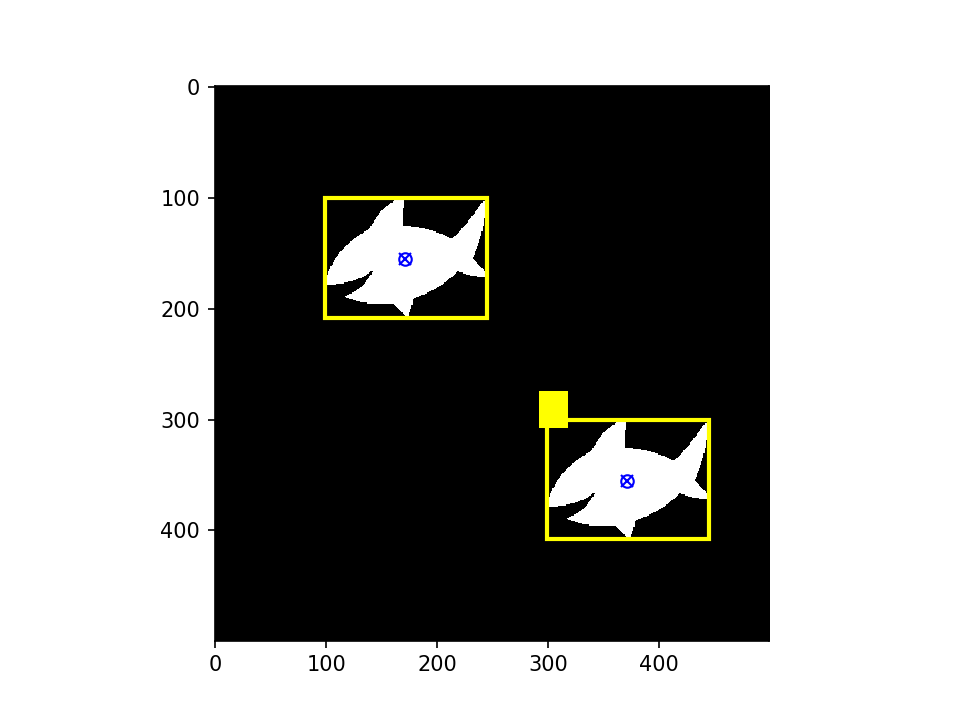

In [8]:
sharks.disp()
blobs.plot_labelbox(color='yellow', thickness=2)

which depicts and labels each blob.  We could also mark the centroids by

In [9]:
blobs.plot_centroid()

which add a marker to the plot above.

# Finding objects in the pixel classification image

A key part of your project will be to develop a deep network to classify each pixel in the image according to whether it belongs to the background, an apple, pear, banana etc.  Each pixel will have a unique value that represents the object class.

We will start by loading a typical image

<IPython.core.display.Javascript object>


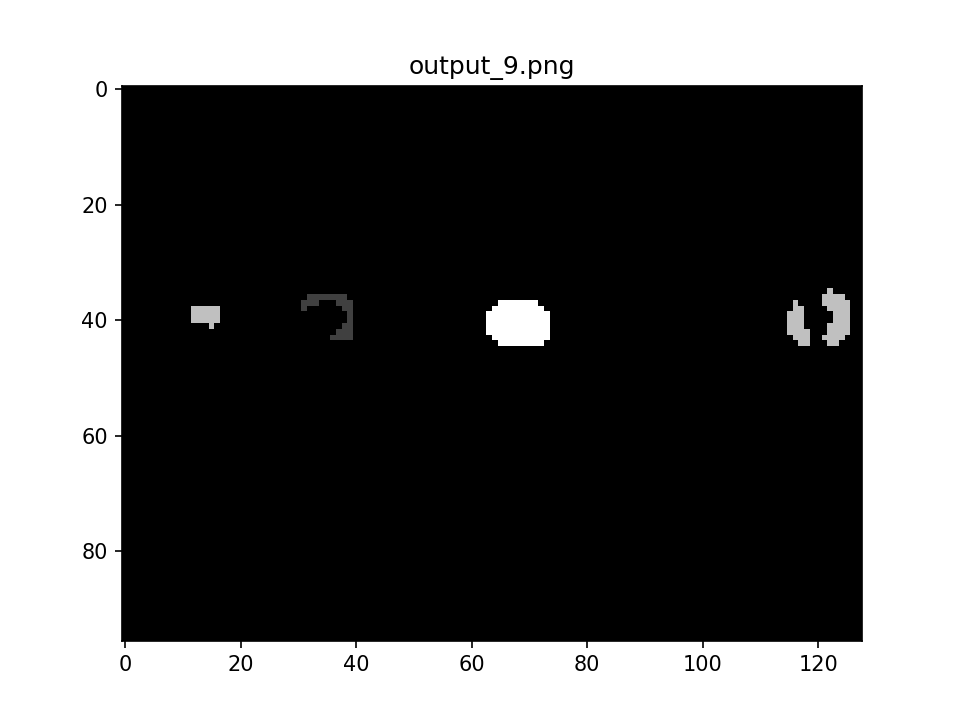

In [10]:
fruitclass = Image('images/output_9.png', grey=True)
fruitclass.disp();

If we hover the mouse cursor over the image, at the bottom right we see the pixel values.  The black background has values of zero, and there are regions with non-zero values that represent particular fruit.  Note that the estimates are far from perfect, there might appear to be big chunks of a fruit missing.

To find which fruit are present we can compute a histogram

<IPython.core.display.Javascript object>


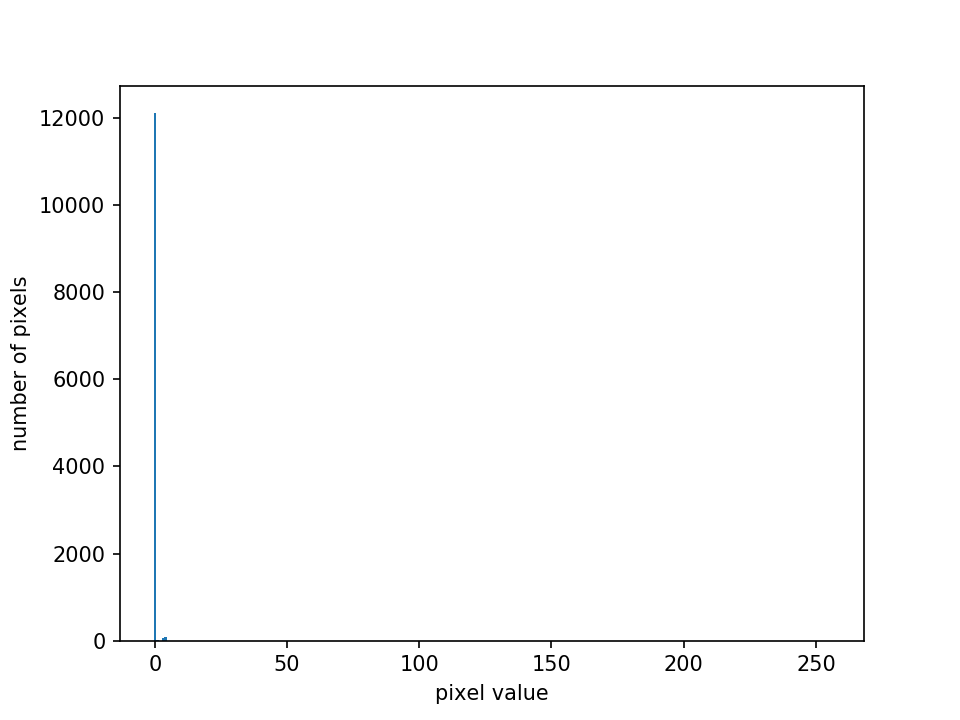

In [11]:
hist = fruitclass.hist()
hist.plot()

Unlike a grey scale image, there are very few unique grey levels in this image, and they are all small values.  You will need to zoom into the histogram to see this.

**Q: There are 3 fruit present, what are their class labels?**

The `hist` object has a number of attributes.  `h` is a 256x1 matrix of histogram values.  For a color image it would be a 256x3 matrix.  `x` is a 

Let make a binary image that shows just the pixels that have a value of 3

<IPython.core.display.Javascript object>


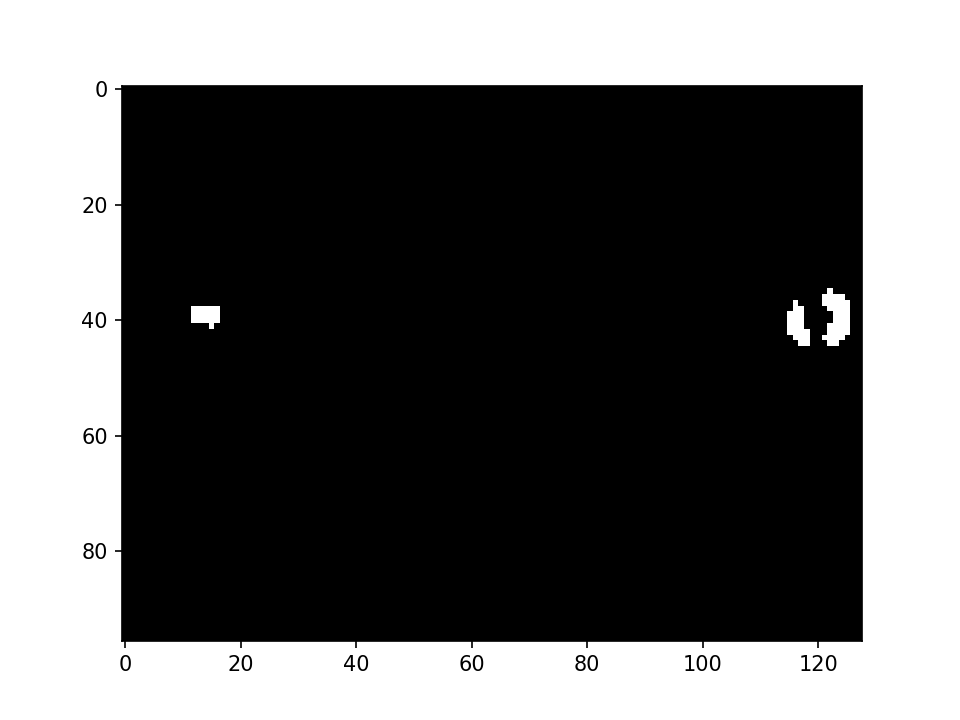

In [12]:
pear = fruitclass == 3
pear.disp();

and we can see that there three blobs here, but due to imperfect pixel classification the middle part of the right-hand pear is missing.

In [13]:
blobs = pear.blobs()

In [14]:
print(blobs)

┌───┬────────┬─────────────┬──────┬───────┬───────┬─────────────┬────────┬────────┐
│id │ parent │    centroid │ area │ touch │ perim │ circularity │ orient │ aspect │
├───┼────────┼─────────────┼──────┼───────┼───────┼─────────────┼────────┼────────┤
│ 0 │     -1 │  14.1, 39.1 │    9 │ False │  12.8 │       0.765 │ -83.9° │  0.968 │
│ 1 │     -1 │ 116.4, 40.9 │ 12.5 │ False │  17.1 │       0.600 │ -66.8° │  0.659 │
│ 2 │     -1 │ 123.2, 39.6 │   23 │ False │  24.1 │       0.552 │ -84.2° │  0.488 │
└───┴────────┴─────────────┴──────┴───────┴───────┴─────────────┴────────┴────────┘



Once again, we can highlight these blob in the image by

<IPython.core.display.Javascript object>


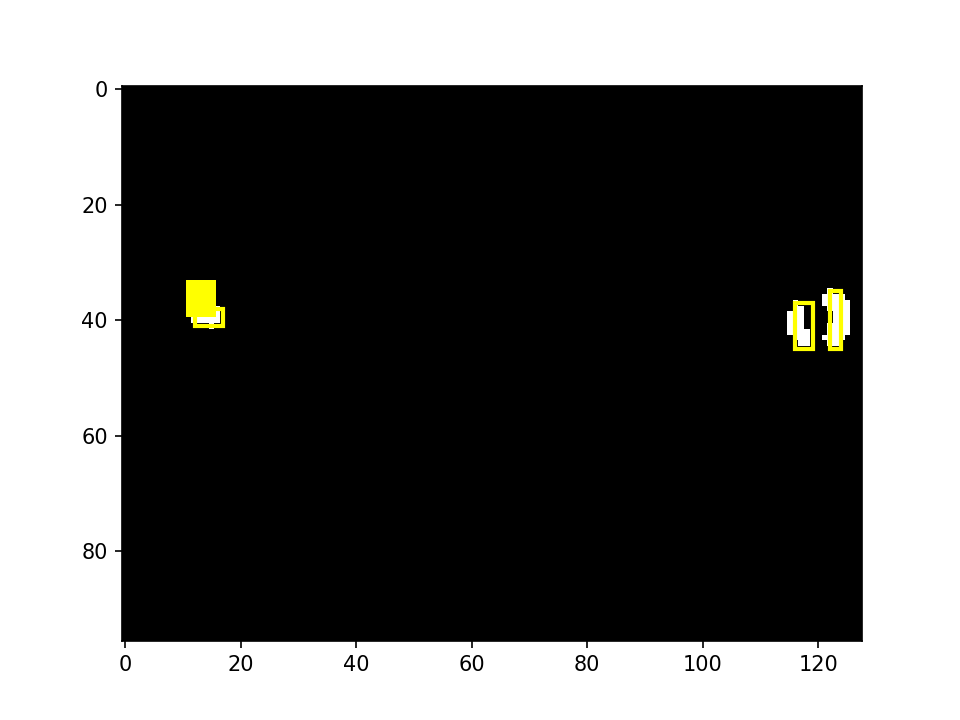

In [15]:
pear.disp()
blobs.plot_labelbox(color='yellow', thickness=2)

# Morphological cleanup

We will now explore a family of computer vision algorithms referred to as mathematical morphology -- morphology because they are concerned with shape.

We will create a small image of a disk

In [16]:
se = Image.kcircle(3)
se

array([[       0,        0,        0,        1,        0,        0,        0],
       [       0,        1,        1,        1,        1,        1,        0],
       [       0,        1,        1,        1,        1,        1,        0],
       [       1,        1,        1,        1,        1,        1,        1],
       [       0,        1,        1,        1,        1,        1,        0],
       [       0,        1,        1,        1,        1,        1,        0],
       [       0,        0,        0,        1,        0,        0,        0]])

which is simply a $7 \times 7$ array with a circular patch of one valued elements.  If we display it as an image

<IPython.core.display.Javascript object>


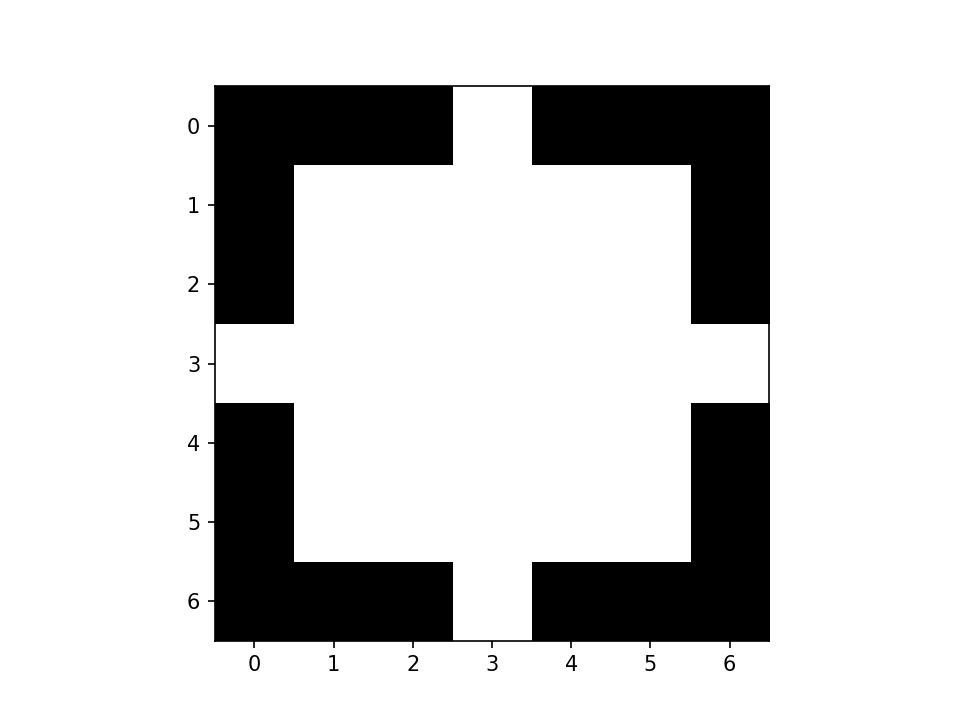

In [17]:
plt.figure()
plt.imshow(se, cmap='gray');

we see that it is a bit ragged but it is hard to do much better with such a small grid.

Now we will perform a morphological *dilation* operation using this disk

<IPython.core.display.Javascript object>


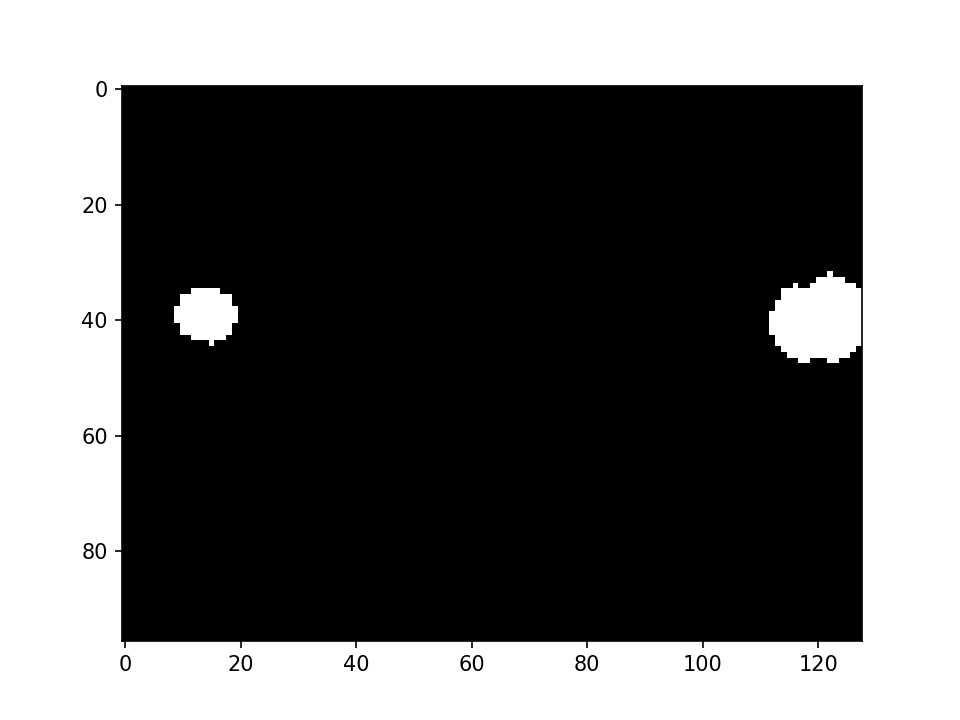

In [18]:
dilated = pear.dilate(se)
dilated.disp();

We can think of this as moving the disk to every point in the image, and if *any* point on the disk touches a one-valued pixel, the result at that location is a one.  Clearly it has filled in the hole, but it has made the blobs bigger.

Now we can perform the inverse operation called morphological *erosion*

<IPython.core.display.Javascript object>


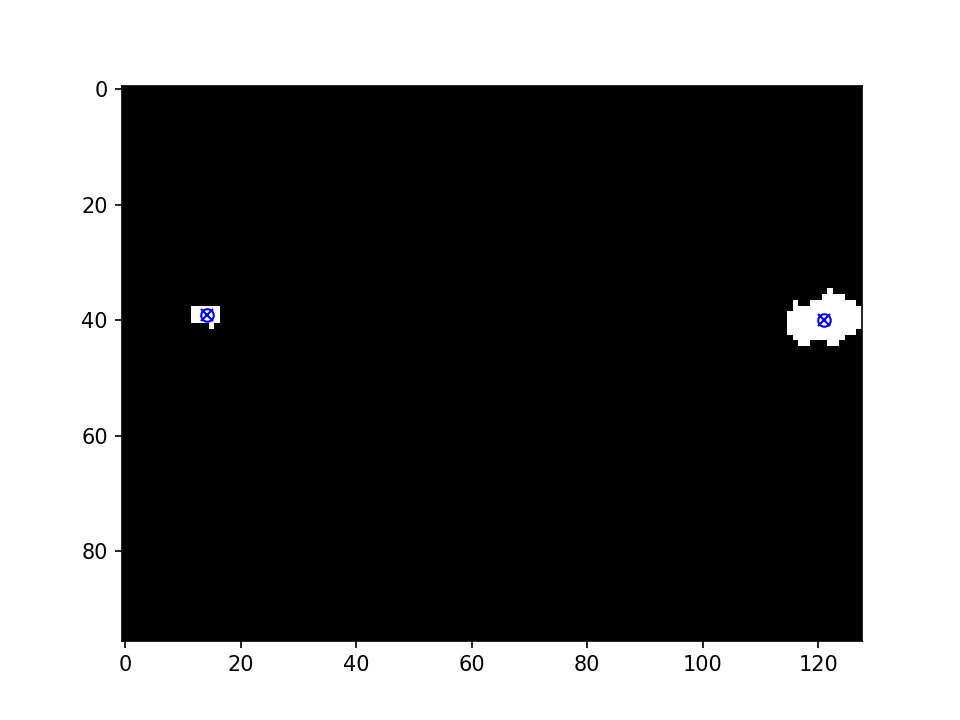

In [19]:
eroded = dilated.erode(se)
eroded.disp();

We can think of this operation as moving the disk to every point in the image, and if *every* point on the disk touches a one-valued pixel, the result at that location is a one.  Clearly it has reduced the blobs back to something like their original size, and it has filled in the hole.

Choosing the radius of the structuring element requires a bit of trial and error (and experience).  Too small and it won't fill the gap, too big and the shape of the object will be lost.

This pair of operations, dilating *then* eroding, is referred to as *closing*.  The `close` method will do this for you in a single hit.  

The converse operation, eroding *then* dilating, is referred to as *opening*. It is useful for the case where two separate objects have been joined together.  This is performed by the `open` method. 

Now we can perform another blob analysis

In [20]:
blobs = eroded.blobs()
print(blobs)
blobs.plot_centroid()

┌───┬────────┬─────────────┬──────┬───────┬───────┬─────────────┬────────┬────────┐
│id │ parent │    centroid │ area │ touch │ perim │ circularity │ orient │ aspect │
├───┼────────┼─────────────┼──────┼───────┼───────┼─────────────┼────────┼────────┤
│ 0 │     -1 │  14.1, 39.1 │    9 │ False │  12.8 │       0.765 │ -83.9° │  0.968 │
│ 1 │     -1 │ 121.0, 40.0 │ 73.5 │ False │  37.2 │       0.742 │  83.2° │  0.974 │
└───┴────────┴─────────────┴──────┴───────┴───────┴─────────────┴────────┴────────┘



## Your turn!

* Find the blobs for other two fruits in this image
* Try this out on one of your own images
* Write the code described below 

┌───┬────────┬────────────┬──────┬───────┬───────┬─────────────┬────────┬────────┐
│id │ parent │   centroid │ area │ touch │ perim │ circularity │ orient │ aspect │
├───┼────────┼────────────┼──────┼───────┼───────┼─────────────┼────────┼────────┤
│ 0 │     -1 │ 68.1, 40.6 │ 63.5 │ False │  29.9 │       0.993 │ -87.9° │  0.943 │
│ 1 │     -1 │ 36.7, 39.0 │   11 │ False │  34.1 │       0.132 │ -64.3° │  0.875 │
└───┴────────┴────────────┴──────┴───────┴───────┴─────────────┴────────┴────────┘



<IPython.core.display.Javascript object>


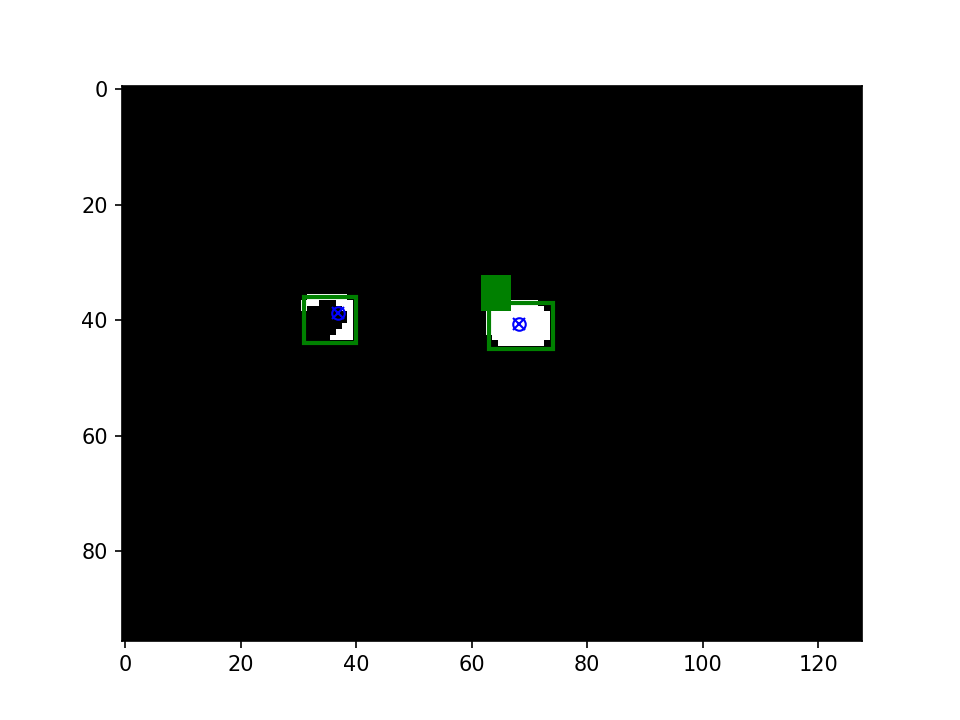

┌───┬────────┬────────────┬──────┬───────┬───────┬─────────────┬────────┬────────┐
│id │ parent │   centroid │ area │ touch │ perim │ circularity │ orient │ aspect │
├───┼────────┼────────────┼──────┼───────┼───────┼─────────────┼────────┼────────┤
│ 0 │     -1 │ 68.1, 40.6 │ 63.5 │ False │  29.9 │       0.993 │ -87.9° │  0.943 │
│ 1 │     -1 │ 36.9, 38.8 │ 18.5 │ False │  32.7 │       0.241 │ -62.9° │  0.867 │
└───┴────────┴────────────┴──────┴───────┴───────┴─────────────┴────────┴────────┘



In [34]:
# Q.  Write code to find the coordinate of the middle of the bottom of the bounding box.  Each blob has a number
#     of useful attributes:
#          uc    horizontal coordinate of the centroid
#          vc    vertical coordinate of the centroid
#          umin  leftmost horizontal coordinate of the blob
#          umax  rightmost horizontal coordinate of the blob
#          vmin  topmost vertical coordinate of the blob
#          vmax  bottommost vertical coordinate of the blob
#
# The blobs object is also an iterator.

others4 = fruitclass ==4
others1  = fruitclass ==1
others = others4+others1
# others.disp();
blobs = others.blobs()
print(blobs)
others.disp()
blobs.plot_labelbox(color='green', thickness=2)
dilated = others.dilate(se)
eroded = dilated.erode(se)
blobs = eroded.blobs()
print(blobs)
blobs.plot_centroid()